# Transformer from Scratch

This notebook implements a **GPT-style Transformer** for character-level text generation.

## Architecture
```
Input → [Embedding + Position] → [Transformer Block] × N → Output

Transformer Block:
    → LayerNorm → Multi-Head Self-Attention → Residual
    → LayerNorm → Feed-Forward Network → Residual
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
print("NumPy ready!")

NumPy ready!


In [2]:
# Load data
with open("data/alice.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()

chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

data = np.array([char2idx[ch] for ch in text], dtype=np.int32)
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

print(f"Vocab: {vocab_size}, Train: {len(train_data):,}, Val: {len(val_data):,}")

Vocab: 46, Train: 133,716, Val: 14,858


In [3]:
# Helper functions
def softmax(x, axis=-1):
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e / np.sum(e, axis=axis, keepdims=True)

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def gelu_backward(x):
    tanh_out = np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3))
    return 0.5 * (1 + tanh_out) + 0.5 * x * (1 - tanh_out**2) * np.sqrt(2/np.pi) * (1 + 3*0.044715*x**2)

def xavier(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / (fan_in + fan_out))

print("Helpers defined!")

Helpers defined!


In [4]:
class Transformer:
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, max_len, dropout=0.1):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.d_ff = d_ff
        self.n_layers = n_layers
        self.max_len = max_len
        self.dropout = dropout
        self.training = True
        
        scale = 0.02 / np.sqrt(n_layers)
        
        self.wte = np.random.randn(vocab_size, d_model) * 0.02
        self.wpe = self._positional_encoding(max_len, d_model)
        
        self.layers = []
        for _ in range(n_layers):
            self.layers.append({
                'W_q': np.random.randn(d_model, d_model) * scale,
                'W_k': np.random.randn(d_model, d_model) * scale,
                'W_v': np.random.randn(d_model, d_model) * scale,
                'W_o': np.random.randn(d_model, d_model) * scale,
                'ln1_g': np.ones(d_model), 'ln1_b': np.zeros(d_model),
                'W_fc': np.random.randn(d_model, d_ff) * scale,
                'b_fc': np.zeros(d_ff),
                'W_proj': np.random.randn(d_ff, d_model) * scale,
                'b_proj': np.zeros(d_model),
                'ln2_g': np.ones(d_model), 'ln2_b': np.zeros(d_model),
            })
        
        self.ln_f_g = np.ones(d_model)
        self.ln_f_b = np.zeros(d_model)
        self.W_out = np.random.randn(d_model, vocab_size) * 0.02
    
    def _positional_encoding(self, max_len, d_model):
        pe = np.zeros((max_len, d_model))
        pos = np.arange(max_len)[:, np.newaxis]
        div = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(pos * div)
        pe[:, 1::2] = np.cos(pos * div)
        return pe
    
    def _dropout(self, x):
        if not self.training or self.dropout == 0:
            return x, None
        mask = (np.random.rand(*x.shape) > self.dropout).astype(np.float64)
        return x * mask / (1 - self.dropout), mask
    
    def _dropout_back(self, dout, mask):
        if mask is None:
            return dout
        return dout * mask / (1 - self.dropout)
    
    def _layer_norm_forward(self, x, g, b, eps=1e-5):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.sqrt(np.var(x, axis=-1, keepdims=True) + eps)
        x_norm = (x - mean) / std
        return g * x_norm + b, (x, x_norm, mean, std, g)
    
    def _layer_norm_backward(self, dout, cache):
        x, x_norm, mean, std, g = cache
        N = x.shape[-1]
        dg = np.sum(dout * x_norm, axis=0)
        db = np.sum(dout, axis=0)
        dx_norm = dout * g
        dvar = np.sum(dx_norm * (x - mean) * -0.5 * std**(-3), axis=-1, keepdims=True)
        dmean = np.sum(dx_norm * -1/std, axis=-1, keepdims=True) + dvar * np.mean(-2*(x-mean), axis=-1, keepdims=True)
        dx = dx_norm / std + dvar * 2*(x-mean)/N + dmean/N
        return dx, dg, db
    
    def _attention_forward(self, x, W_q, W_k, W_v, W_o, mask):
        T, D = x.shape
        Q, K, V = x @ W_q, x @ W_k, x @ W_v
        
        Q = Q.reshape(T, self.n_heads, self.d_k).transpose(1, 0, 2)
        K = K.reshape(T, self.n_heads, self.d_k).transpose(1, 0, 2)
        V = V.reshape(T, self.n_heads, self.d_k).transpose(1, 0, 2)
        
        scores = (Q @ K.transpose(0, 2, 1)) / np.sqrt(self.d_k) + mask
        attn = softmax(scores, axis=-1)
        attn_drop, attn_mask = self._dropout(attn)
        
        context = attn_drop @ V
        context = context.transpose(1, 0, 2).reshape(T, D)
        out = context @ W_o
        out, out_mask = self._dropout(out)
        
        return out, attn, (x, Q, K, V, attn, attn_drop, context, W_q, W_k, W_v, W_o, attn_mask, out_mask)
    
    def _attention_backward(self, dout, cache):
        x, Q, K, V, attn, attn_drop, context, W_q, W_k, W_v, W_o, attn_mask, out_mask = cache
        T, D = x.shape
        
        dout = self._dropout_back(dout, out_mask)
        dW_o = context.T @ dout
        dcontext = (dout @ W_o.T).reshape(T, self.n_heads, self.d_k).transpose(1, 0, 2)
        
        dattn_drop = dcontext @ V.transpose(0, 2, 1)
        dV = attn_drop.transpose(0, 2, 1) @ dcontext
        dattn = self._dropout_back(dattn_drop, attn_mask)
        
        dscores = attn * (dattn - np.sum(dattn * attn, axis=-1, keepdims=True)) / np.sqrt(self.d_k)
        dQ = dscores @ K
        dK = dscores.transpose(0, 2, 1) @ Q
        
        dQ = dQ.transpose(1, 0, 2).reshape(T, D)
        dK = dK.transpose(1, 0, 2).reshape(T, D)
        dV = dV.transpose(1, 0, 2).reshape(T, D)
        
        dW_q, dW_k, dW_v = x.T @ dQ, x.T @ dK, x.T @ dV
        dx = dQ @ W_q.T + dK @ W_k.T + dV @ W_v.T
        return dx, dW_q, dW_k, dW_v, dW_o
    
    def _ffn_forward(self, x, W_fc, b_fc, W_proj, b_proj):
        h = x @ W_fc + b_fc
        h_act = gelu(h)
        h_drop, h_mask = self._dropout(h_act)
        out = h_drop @ W_proj + b_proj
        out, out_mask = self._dropout(out)
        return out, (x, h, h_act, W_fc, W_proj, h_mask, out_mask)
    
    def _ffn_backward(self, dout, cache):
        x, h, h_act, W_fc, W_proj, h_mask, out_mask = cache
        dout = self._dropout_back(dout, out_mask)
        dW_proj = h_act.T @ dout
        db_proj = np.sum(dout, axis=0)
        dh_act = self._dropout_back(dout @ W_proj.T, h_mask)
        dh = dh_act * gelu_backward(h)
        dW_fc = x.T @ dh
        db_fc = np.sum(dh, axis=0)
        dx = dh @ W_fc.T
        return dx, dW_fc, db_fc, dW_proj, db_proj
    
    def forward(self, input_ids):
        T = len(input_ids)
        x = self.wte[input_ids] + self.wpe[:T]
        x, self.emb_mask = self._dropout(x)
        mask = np.triu(np.ones((T, T)) * (-1e9), k=1)
        
        self.cache = {'input_ids': input_ids}
        self.layer_caches = []
        
        for layer in self.layers:
            lc = {}
            x_ln1, lc['ln1'] = self._layer_norm_forward(x, layer['ln1_g'], layer['ln1_b'])
            attn_out, _, lc['attn'] = self._attention_forward(x_ln1, layer['W_q'], layer['W_k'], layer['W_v'], layer['W_o'], mask)
            x = x + attn_out
            x_ln2, lc['ln2'] = self._layer_norm_forward(x, layer['ln2_g'], layer['ln2_b'])
            ffn_out, lc['ffn'] = self._ffn_forward(x_ln2, layer['W_fc'], layer['b_fc'], layer['W_proj'], layer['b_proj'])
            x = x + ffn_out
            self.layer_caches.append(lc)
        
        x_final, self.cache['ln_f'] = self._layer_norm_forward(x, self.ln_f_g, self.ln_f_b)
        self.cache['x_final'] = x_final
        return x_final @ self.W_out
    
    def backward(self, dlogits):
        self.dW_out = self.cache['x_final'].T @ dlogits
        dx = dlogits @ self.W_out.T
        dx, self.dln_f_g, self.dln_f_b = self._layer_norm_backward(dx, self.cache['ln_f'])
        
        self.dlayers = []
        for i in reversed(range(self.n_layers)):
            lc = self.layer_caches[i]
            dl = {}
            dx_ffn, dl['dW_fc'], dl['db_fc'], dl['dW_proj'], dl['db_proj'] = self._ffn_backward(dx, lc['ffn'])
            dx_ln2, dl['dln2_g'], dl['dln2_b'] = self._layer_norm_backward(dx_ffn, lc['ln2'])
            dx = dx + dx_ln2
            dx_attn, dl['dW_q'], dl['dW_k'], dl['dW_v'], dl['dW_o'] = self._attention_backward(dx, lc['attn'])
            dx_ln1, dl['dln1_g'], dl['dln1_b'] = self._layer_norm_backward(dx_attn, lc['ln1'])
            dx = dx + dx_ln1
            self.dlayers.insert(0, dl)
        
        dx = self._dropout_back(dx, self.emb_mask)
        self.dwte = np.zeros_like(self.wte)
        for t, idx in enumerate(self.cache['input_ids']):
            self.dwte[idx] += dx[t]
    
    def get_params_and_grads(self):
        params, grads = [], []
        params.append(self.wte); grads.append(self.dwte)
        params.append(self.W_out); grads.append(self.dW_out)
        params.extend([self.ln_f_g, self.ln_f_b])
        grads.extend([self.dln_f_g, self.dln_f_b])
        for layer, dl in zip(self.layers, self.dlayers):
            params.extend([layer['W_q'], layer['W_k'], layer['W_v'], layer['W_o'], layer['ln1_g'], layer['ln1_b'],
                          layer['W_fc'], layer['b_fc'], layer['W_proj'], layer['b_proj'], layer['ln2_g'], layer['ln2_b']])
            grads.extend([dl['dW_q'], dl['dW_k'], dl['dW_v'], dl['dW_o'], dl['dln1_g'], dl['dln1_b'],
                         dl['dW_fc'], dl['db_fc'], dl['dW_proj'], dl['db_proj'], dl['dln2_g'], dl['dln2_b']])
        return params, grads

print("Transformer defined!")

Transformer defined!


In [5]:
class AdamW:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        self.lr = lr
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.weight_decay = weight_decay
        self.m, self.v, self.t = {}, {}, 0
    
    def step(self, params, grads):
        self.t += 1
        for i, (p, g) in enumerate(zip(params, grads)):
            if i not in self.m:
                self.m[i] = np.zeros_like(g)
                self.v[i] = np.zeros_like(g)
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p -= self.lr * (m_hat / (np.sqrt(v_hat) + self.eps) + self.weight_decay * p)
    
    def set_lr(self, lr):
        self.lr = lr

def cross_entropy_loss(logits, targets):
    probs = softmax(logits, axis=-1)
    loss = sum(-np.log(probs[t, targets[t]] + 1e-12) for t in range(len(targets)))
    d_logits = probs.copy()
    for t in range(len(targets)):
        d_logits[t, targets[t]] -= 1
    return loss, d_logits

def get_lr(step, warmup, max_steps, max_lr, min_lr):
    if step < warmup:
        return max_lr * step / warmup
    decay = (step - warmup) / (max_steps - warmup)
    return min_lr + 0.5 * (1 + np.cos(np.pi * decay)) * (max_lr - min_lr)

print("Optimizer defined!")

Optimizer defined!


In [9]:
# Configuration - balanced for speed and quality
d_model = 128
n_heads = 4
d_ff = 512
n_layers = 4
max_len = 128
seq_len = 64  # Back to 64 for faster convergence
dropout = 0.1
max_lr = 0.0015  # Slightly higher
min_lr = 0.0001
warmup_iters = 500  # Faster warmup
num_iterations = 100000

print(f"Config: d={d_model}, heads={n_heads}, layers={n_layers}, seq={seq_len}, dropout={dropout}")

np.random.seed(42)
model = Transformer(vocab_size, d_model, n_heads, d_ff, n_layers, max_len, dropout)
optimizer = AdamW(lr=max_lr, weight_decay=0.01)

total = model.wte.size + model.W_out.size + model.ln_f_g.size * 2
for layer in model.layers:
    total += sum(v.size for v in layer.values())
print(f"Parameters: {total:,}")

Config: d=128, heads=4, layers=4, seq=64, dropout=0.1
Parameters: 803,072


In [10]:
def generate(seed, length=100, temperature=0.8):
    model.training = False
    tokens = [char2idx[ch] for ch in seed if ch in char2idx]
    for _ in range(length):
        input_ids = np.array(tokens[-max_len:])
        logits = model.forward(input_ids)
        probs = softmax(logits[-1] / temperature)
        tokens.append(np.random.choice(len(probs), p=probs))
    model.training = True
    return ''.join(idx2char[t] for t in tokens)

print("Generate defined!")

Generate defined!


In [11]:
T = seq_len
pointer = 0
smooth_loss = -np.log(1.0/vocab_size) * T
loss_history = []

# Use multiple sequences per batch for faster learning
batch_size = 4

print("Training Transformer...")
print("="*70)

for iteration in range(num_iterations):
    lr = get_lr(iteration, warmup_iters, num_iterations, max_lr, min_lr)
    optimizer.set_lr(lr)
    
    # Accumulate gradients over mini-batch
    total_loss = 0
    all_grads = None
    
    for b in range(batch_size):
        if pointer + T + 1 >= len(train_data):
            pointer = np.random.randint(0, len(train_data) - T - 1)
        
        inputs = train_data[pointer:pointer+T]
        targets = train_data[pointer+1:pointer+T+1]
        
        model.training = True
        logits = model.forward(inputs)
        loss, d_logits = cross_entropy_loss(logits, targets)
        model.backward(d_logits)
        
        total_loss += loss
        
        params, grads = model.get_params_and_grads()
        if all_grads is None:
            all_grads = [g.copy() for g in grads]
        else:
            for i, g in enumerate(grads):
                all_grads[i] += g
        
        pointer += T
    
    # Average gradients
    for g in all_grads:
        g /= batch_size
    
    # Gradient clipping
    grad_norm = np.sqrt(sum(np.sum(g**2) for g in all_grads))
    if grad_norm > 1.0:
        for g in all_grads:
            g *= 1.0 / grad_norm
    
    optimizer.step(params, all_grads)
    
    avg_loss = total_loss / batch_size
    smooth_loss = 0.99 * smooth_loss + 0.01 * avg_loss
    loss_history.append(smooth_loss)
    
    if iteration % 5000 == 0:
        print(f"Iter {iteration:6d} | Loss: {smooth_loss:.2f} | Per-char: {smooth_loss/T:.3f} | LR: {lr:.6f}")
        print(f"Sample: {generate('alice ', 100, 0.8)}")
        print("-"*70)

Training Transformer...
Iter      0 | Loss: 245.04 | Per-char: 3.829 | LR: 0.000000
Sample: alice ubhem?cu )]b*oojo *,q:ta0uq:(bxm)*ce_p[dot(ef)uw`)[sfe"sfki,*';eu[s!0j3;3sl)cw0rx._xe,jvujv(qnuukl'r
----------------------------------------------------------------------
Iter   5000 | Loss: 114.67 | Per-char: 1.792 | LR: 0.001493
Sample: alice a not agan it to mining the knought.

  `the hureer, and tareveveleaw camertomin wtherd mure w werer
----------------------------------------------------------------------
Iter  10000 | Loss: 99.80 | Per-char: 1.559 | LR: 0.001469
Sample: alice up saidon tance.

  `-the marcess part ran, what well a bee alofoundind shereadeasond thearconerpy o
----------------------------------------------------------------------
Iter  15000 | Loss: 90.24 | Per-char: 1.410 | LR: 0.001428
Sample: alice at
she had more such as the had came went to have the knave w ow oither qusogllinthrint hin harp, th
-----------------------------------------------------------------

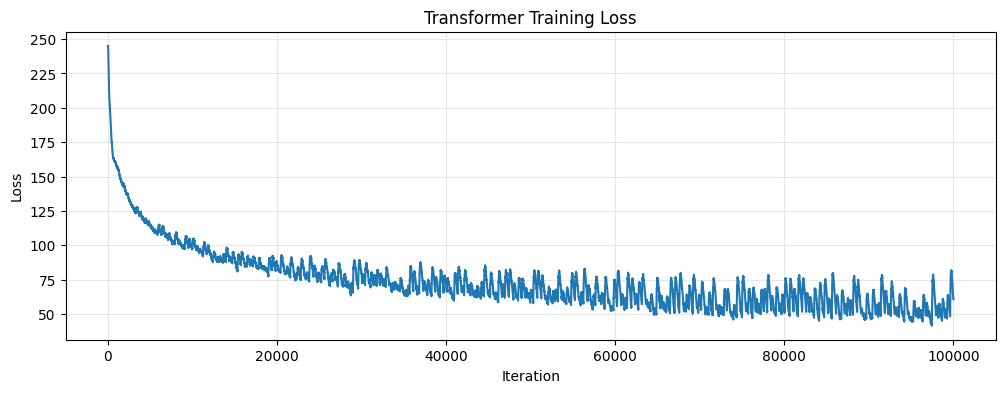

Final loss: 60.67
Per-char loss: 0.948


In [12]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Transformer Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_history[-1]:.2f}")
print(f"Per-char loss: {loss_history[-1]/T:.3f}")

In [13]:
# Generate samples
print("="*60)
print("GENERATED SAMPLES")
print("="*60)

for seed in ["alice ", "the queen ", "'what ", "said the "]:
    print(f"\nSeed: '{seed}'")
    print("-"*40)
    print(generate(seed, 150, 0.4))
    print()

GENERATED SAMPLES

Seed: 'alice '
----------------------------------------
alice could see, who had not attended to alice, and the moral of thared
of theroneneand theloniso ond touglanistof hestonegroncherof athed ther th, theshele


Seed: 'the queen '
----------------------------------------
the queen said--'

  `what did the twinkling and more all that,' said thexinthe so sond the athe arosthe at sourtheanthelofremaroploremarere; arrinofthinofthema


Seed: ''what '
----------------------------------------
'what you would see them wrong and she had got its head.  so she shetilloooooooooow he he gould
gort hinderthinoffanoryeseanonowndeselelesined therof therou


Seed: 'said the '
----------------------------------------
said the king:  `come on!' said the mock turtle.

  `it must be the ha,'disaigon theathe the fire thindin thin hithin an fat thinonof ouratherroff athentherea 



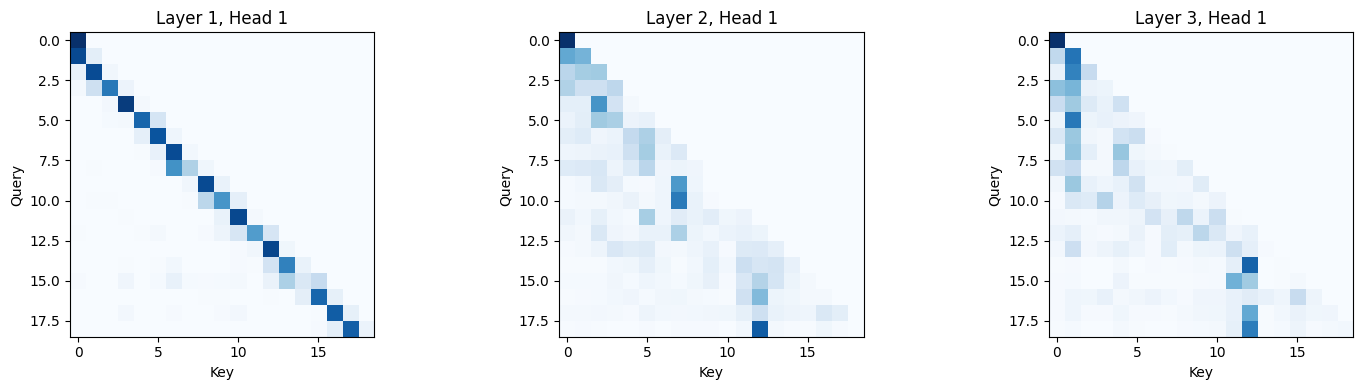

In [14]:
# Visualize attention
def get_attention_weights(text):
    input_ids = np.array([char2idx[ch] for ch in text if ch in char2idx])
    T = len(input_ids)
    
    x = model.wte[input_ids] + model.wpe[:T]
    mask = np.triu(np.ones((T, T)) * (-1e9), k=1)
    
    all_attn = []
    for layer in model.layers:
        x_ln, _ = model._layer_norm_forward(x, layer['ln1_g'], layer['ln1_b'])
        attn_out, attn_w, _ = model._attention_forward(
            x_ln, layer['W_q'], layer['W_k'], layer['W_v'], layer['W_o'], mask
        )
        x = x + attn_out
        x_ln2, _ = model._layer_norm_forward(x, layer['ln2_g'], layer['ln2_b'])
        ffn_out, _ = model._ffn_forward(x_ln2, layer['W_fc'], layer['b_fc'], layer['W_proj'], layer['b_proj'])
        x = x + ffn_out
        all_attn.append(attn_w)
    
    return all_attn

# Visualize
text = "alice was beginning"
attns = get_attention_weights(text)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    attn = attns[i][0]  # First head
    im = ax.imshow(attn, cmap='Blues')
    ax.set_title(f'Layer {i+1}, Head 1')
    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
plt.tight_layout()
plt.show()


### Key Takeaways

1. **Transformers need more data** - They shine with large datasets
2. **Parallel processing** - Unlike RNN/LSTM, all positions computed at once
3. **Self-attention** - Each position attends to all positions
4. **Foundation of modern LLMs** - GPT, BERT, Claude all use this architecture

### Architecture Components

| Component | Formula |
|-----------|--------|
| Self-Attention | softmax(QK^T/√d) × V |
| Multi-Head | Concat(head_1...head_h) × W_O |
| FFN | GELU(xW_1 + b_1)W_2 + b_2 |
| Layer Norm | γ(x-μ)/σ + β |
| Residual | x + sublayer(x) |